## Detection of pulsars in High Time Resolution Universe Survey 2 (HTRU2) data

Compares the various vanilla classifiers in sklearn on the online pulsar candidate selection data of Lyon et al., arXiv:1603.05166. Modulo computing time, which is not compared, the performances achieved by some of these classifers beat those obtained by Lyon et al.'s best-performing classifiers: neural networks and custom-made decision trees.  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("HTRU_2.csv", header = None)

In [3]:
df.columns = ['ip_mean','ip_SD','ip_kurtosis','ip_skewness',
              'dm_snr_mean','dm_snr_SD','dm_snr_kurtosis','dm_snr_skewness', 
              'pulsar_no_pulsar'] 
# ip = integrated profile of the pulse
# dm = dispersion measure; dispersion is induced by propagation through interstellar medium and is related to electron column density
# snr = signal to noise ratio
# dm_snr = dm vs snr plot

In [4]:
df[:5]

,ip_mean,ip_SD,ip_kurtosis,ip_skewness,dm_snr_mean,dm_snr_SD,dm_snr_kurtosis,dm_snr_skewness,pulsar_no_pulsar
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0


In [5]:
df.isna().sum().sum()

0

#### Look at class imbalance:

In [6]:
df[df["pulsar_no_pulsar"]==0].shape[0], df[df["pulsar_no_pulsar"]==1].shape[0]

(16259, 1639)

#### Try a few scatter plots:

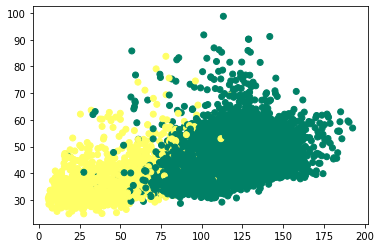

In [7]:
plt.scatter(df["ip_mean"],df["ip_SD"],c=df["pulsar_no_pulsar"],cmap=plt.cm.summer)

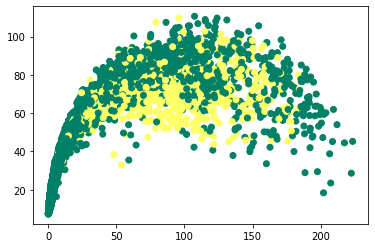

In [8]:
plt.scatter(df["dm_snr_mean"],df["dm_snr_SD"],c=df["pulsar_no_pulsar"],cmap=plt.cm.summer)

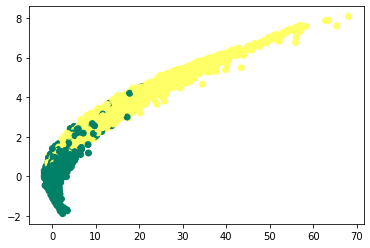

In [9]:
plt.scatter(df["ip_skewness"],df["ip_kurtosis"],c=df["pulsar_no_pulsar"],cmap=plt.cm.summer)

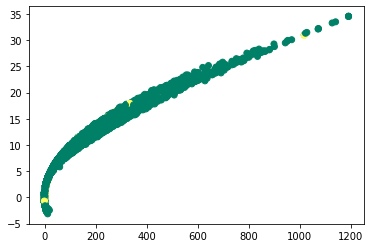

In [10]:
plt.scatter(df["dm_snr_skewness"],df["dm_snr_kurtosis"],c=df["pulsar_no_pulsar"],cmap=plt.cm.summer)

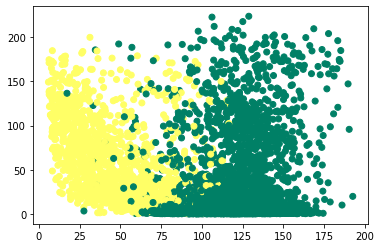

In [11]:
plt.scatter(df["ip_mean"],df["dm_snr_mean"],c=df["pulsar_no_pulsar"],cmap=plt.cm.summer)

#### For fair comparison with Lyon et al., split data into train and test set in the same proportion:

In [12]:
np.random_seed = 42

In [13]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df,stratify=df["pulsar_no_pulsar"],test_size=0.33) 
Xtrain = train.drop("pulsar_no_pulsar", axis=1) 
ytrain = train["pulsar_no_pulsar"].copy()
Xtest = test.drop("pulsar_no_pulsar", axis=1) 
ytest = test["pulsar_no_pulsar"].copy()

In [14]:
from sklearn.preprocessing import StandardScaler
StandardScaler = StandardScaler()

In [15]:
StandardScaler.fit_transform(Xtrain);
StandardScaler.fit_transform(Xtest);

#### Fit non-parametric classifiers:

In [16]:
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier

In [17]:
gradboost = GradientBoostingClassifier()
adaboost = AdaBoostClassifier() # Equivalent to using GradientBoostingClassifier with exponential loss!
forest = RandomForestClassifier(n_estimators=10)

In [18]:
gradboost.fit(Xtrain,ytrain), adaboost.fit(Xtrain,ytrain), forest.fit(Xtrain,ytrain)

(GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                            learning_rate=0.1, loss='deviance', max_depth=3,
                            max_features=None, max_leaf_nodes=None,
                            min_impurity_decrease=0.0, min_impurity_split=None,
                            min_samples_leaf=1, min_samples_split=2,
                            min_weight_fraction_leaf=0.0, n_estimators=100,
                            n_iter_no_change=None, presort='deprecated',
                            random_state=None, subsample=1.0, tol=0.0001,
                            validation_fraction=0.1, verbose=0,
                            warm_start=False),
 AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                    n_estimators=50, random_state=None),
 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=None, max_features='auto',
 

In [19]:
gradboost_predict = gradboost.predict(Xtrain)
adaboost_predict = adaboost.predict(Xtrain) 
forest_predict = forest.predict(Xtrain)

In [20]:
from sklearn.metrics import f1_score
f1_score(ytrain,gradboost_predict),f1_score(ytrain,adaboost_predict),f1_score(ytrain,forest_predict)

(0.9230046948356808, 0.8742690058479532, 0.9825046040515653)

In [21]:
from sklearn.model_selection import cross_val_score

gradboost_scores = cross_val_score(gradboost, Xtrain, ytrain, scoring="f1", cv=10) 
adaboost_scores = cross_val_score(adaboost, Xtrain, ytrain, scoring="f1", cv=10) 
forest_scores = cross_val_score(forest, Xtrain, ytrain, scoring="f1", cv=10) 

gradboost_scores.mean(),adaboost_scores.mean(), forest_scores.mean()

(0.8686626969776841, 0.8690756296242427, 0.8742391605856443)

#### See if parametric classifiers can compete and select the most appropriate model:

In [22]:
from sklearn.svm import SVC
svcpt1 = SVC(C=0.1,kernel='rbf')
svc1   = SVC(      kernel='rbf') #Default value of C is 1.
svc10  = SVC(C=10.,kernel='rbf') 
svcpt1.fit(Xtrain,ytrain)
svc1.fit(Xtrain,ytrain)
svc10.fit(Xtrain,ytrain)
svcpt1_predict = svcpt1.predict(Xtrain)
svc1_predict = svc1.predict(Xtrain)
svc10_predict = svc10.predict(Xtrain)
f1_score(ytrain,svcpt1_predict),f1_score(ytrain,svc1_predict), f1_score(ytrain,svc10_predict)

(0.8167701863354037, 0.8326572008113591, 0.8404040404040404)

In [23]:
svcpt1_scores = cross_val_score(svcpt1, Xtrain, ytrain, scoring="f1", cv=10)
svc1_scores = cross_val_score(svc1, Xtrain, ytrain, scoring="f1", cv=10)
svc10_scores = cross_val_score(svc10, Xtrain, ytrain, scoring="f1", cv=10)
svcpt1_scores.mean(), svc1_scores.mean(), svc10_scores.mean()

(0.8120348951570667, 0.8295129152151353, 0.8365261433753627)

In [24]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
qda = QuadraticDiscriminantAnalysis()

In [25]:
lda.fit(Xtrain,ytrain), qda.fit(Xtrain,ytrain)

(LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                            solver='svd', store_covariance=False, tol=0.0001),
 QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
                               store_covariance=False, tol=0.0001))

In [26]:
lda_predict = lda.predict(Xtrain)
qda_predict = qda.predict(Xtrain)

In [27]:
f1_score(ytrain,lda_predict),f1_score(ytrain,qda_predict)

(0.8496993987975952, 0.8285968028419183)

In [28]:
lda_score = cross_val_score(lda, Xtrain, ytrain, scoring="f1", cv=10).mean()
qda_score = cross_val_score(qda, Xtrain, ytrain, scoring="f1", cv=10).mean()
lda_score, qda_score

(0.8484941746643331, 0.8261784255053535)

In [29]:
from sklearn.linear_model import LogisticRegression
logistic = LogisticRegression(C=1.0,max_iter=1000)

In [30]:
logistic.fit(Xtrain,ytrain)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [31]:
logistic_predict = logistic.predict(Xtrain)

In [32]:
f1_score(ytrain,logistic_predict)

0.8771248178727539

In [33]:
logistic_score = cross_val_score(logistic, Xtrain, ytrain, scoring="f1", cv=10).mean()
logistic_score

0.875836994766245

#### Hyperparameter tuning on the selected classifier:

In [34]:
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV
distributions = dict(C=uniform(loc=0, scale=4))
clf = RandomizedSearchCV(logistic, distributions)

In [35]:
search = clf.fit(Xtrain,ytrain)

In [36]:
search.best_params_

{'C': 2.275341886305866}

In [37]:
logistic = LogisticRegression ( C = search.best_params_.get('C'), max_iter=1000 )
logistic.fit(Xtrain,ytrain)
logistic_predict = logistic.predict(Xtrain)
f1_score(ytrain,logistic_predict)

0.8776699029126213

In [38]:
logistic_score = cross_val_score(logistic, Xtrain, ytrain, scoring="f1", cv=10).mean()
logistic_score

0.8758248185580785

#### Performances on the test set:

In [39]:
gradboost_predict = gradboost.predict(Xtest)
f1_score(ytest,gradboost_predict)

0.8829174664107485

In [40]:
svc10_predict = svc10.predict(Xtest)
f1_score(ytest,svc10_predict)

0.8474226804123711

In [41]:
lda_predict = lda.predict(Xtest)
f1_score(ytest,lda_predict)

0.8468653648509764

In [42]:
logistic_predict = logistic.predict(Xtest)
f1_score(ytest,logistic_predict)

0.8774703557312252